# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:


import os
from os.path import join as osj
import os.path as osp

# Point to AFDB, not Arrhythmia DB
PROJECT_PATH = "/content/drive/MyDrive/files"  # <-- AFDB folder
DATA_ROOT    = PROJECT_PATH
os.makedirs(DATA_ROOT, exist_ok=True)

# AFDB record IDs are not 100..234; discover by .dat files
RECORDS = sorted({osp.splitext(f)[0] for f in os.listdir(DATA_ROOT) if f.endswith(".dat")})

print("PROJECT_PATH:", PROJECT_PATH)
print("DATA_ROOT   :", DATA_ROOT)
print("Total records found:", len(RECORDS))
print("Sample:", RECORDS[:10])

project_path = DATA_ROOT
patient_ids = RECORDS

PROJECT_PATH: /content/drive/MyDrive/files
DATA_ROOT   : /content/drive/MyDrive/files
Total records found: 23
Sample: ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261']


In [ ]:
# wfdb is not normally installed in Colab
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 148.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [ ]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

## **A2: Basic Visualization of ECG**
Basic code for loading (reading), plotting and playing with ECG signals

### **a. Getting Recordings' IDs**
The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings.

In [ ]:
patient_ids = RECORDS
patient_ids

['04015',
 '04043',
 '04048',
 '04126',
 '04746',
 '04908',
 '04936',
 '05091',
 '05121',
 '05261',
 '06426',
 '06453',
 '06995',
 '07162',
 '07859',
 '07879',
 '07910',
 '08215',
 '08219',
 '08378',
 '08405',
 '08434',
 '08455']

### **b. 1 Patient ECG loading and plotting**
Extracting 2 leads ECG signals of a patient (for example: 100), and saving in two lists.

<class 'numpy.ndarray'>
(9205760,)
{'fs': 250, 'sig_len': 9205760, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(9, 0), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': []}


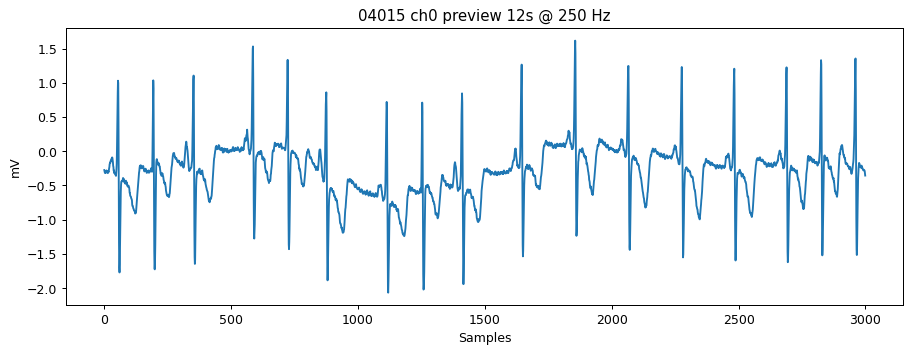

In [ ]:
# Extract and preview one AFDB record
lead0 = {}
lead1 = {}

patient_id = patient_ids[0]  # pick the first available AFDB record
signals, info = wfdb.rdsamp(osj(DATA_ROOT, str(patient_id)))

n_channels = signals.shape[1]
# Always guard channel indexing
lead0[patient_id] = signals[:, 0]
if n_channels > 1:
    lead1[patient_id] = signals[:, 1]

print(type(lead0[patient_id]))
print(lead0[patient_id].shape)
print(info)  # includes fs, sig_name, units, comments

# Preview ~12 seconds using the true sampling rate (no hardcode)
fs = int(info['fs'])
preview_secs = 12
a = lead0[patient_id][0: preview_secs * fs]

plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title(f"{patient_id} ch0 preview {preview_secs}s @ {fs} Hz")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.show()

### **c. All patients' ECG loading**

In [ ]:
def get_ecg_preview(patient_ids, seconds=10, channel=0, at_seconds=0):
    """
    Return a short preview window per record (avoids loading multi-hour signals).
    """
    previews = {}
    infos = {}
    for rid in patient_ids:
        rec_path = osj(DATA_ROOT, str(rid))
        # Tiny read to get fs
        _, inf0 = wfdb.rdsamp(rec_path, sampfrom=0, sampto=1)
        fs = int(inf0['fs'])
        start = max(0, int(at_seconds * fs))
        stop  = start + int(seconds * fs)
        sig, inf = wfdb.rdsamp(rec_path, sampfrom=start, sampto=stop)
        ch = min(channel, sig.shape[1] - 1)
        previews[rid] = sig[:, ch]
        infos[rid] = inf
        print(f'Loaded preview for {rid}: {seconds}s @ {fs}Hz, ch{ch}')
    return previews, infos

def get_ecg_info(record_id):
    rec_path = osj(DATA_ROOT, str(record_id))
    _, info = wfdb.rdsamp(rec_path, sampfrom=0, sampto=1)
    return info

In [ ]:
# lead0, lead1 = get_ecg_signals(patient_ids)
lead_preview, info_preview = get_ecg_preview(patient_ids, seconds=10, channel=0, at_seconds=0)

Loaded preview for 04015: 10s @ 250Hz, ch0
Loaded preview for 04043: 10s @ 250Hz, ch0
Loaded preview for 04048: 10s @ 250Hz, ch0
Loaded preview for 04126: 10s @ 250Hz, ch0
Loaded preview for 04746: 10s @ 250Hz, ch0
Loaded preview for 04908: 10s @ 250Hz, ch0
Loaded preview for 04936: 10s @ 250Hz, ch0
Loaded preview for 05091: 10s @ 250Hz, ch0
Loaded preview for 05121: 10s @ 250Hz, ch0
Loaded preview for 05261: 10s @ 250Hz, ch0
Loaded preview for 06426: 10s @ 250Hz, ch0
Loaded preview for 06453: 10s @ 250Hz, ch0
Loaded preview for 06995: 10s @ 250Hz, ch0
Loaded preview for 07162: 10s @ 250Hz, ch0
Loaded preview for 07859: 10s @ 250Hz, ch0
Loaded preview for 07879: 10s @ 250Hz, ch0
Loaded preview for 07910: 10s @ 250Hz, ch0
Loaded preview for 08215: 10s @ 250Hz, ch0
Loaded preview for 08219: 10s @ 250Hz, ch0
Loaded preview for 08378: 10s @ 250Hz, ch0
Loaded preview for 08405: 10s @ 250Hz, ch0
Loaded preview for 08434: 10s @ 250Hz, ch0
Loaded preview for 08455: 10s @ 250Hz, ch0


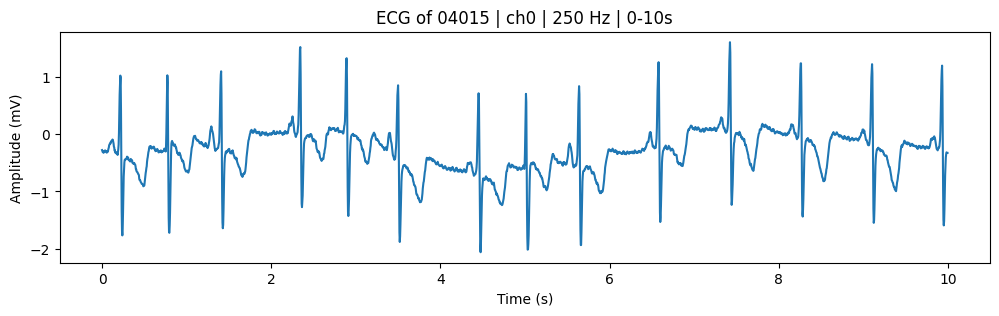

In [ ]:
# Choose any AFDB record and a time window (in seconds)
patient_id = patient_ids[0]   # change as needed
starting_time = 0             # seconds
ending_time   = 10            # seconds

# Read only the needed window
_, inf0 = wfdb.rdsamp(osj(DATA_ROOT, str(patient_id)), sampfrom=0, sampto=1)
fs = int(inf0['fs'])
start_idx = int(starting_time * fs)
end_idx   = int(ending_time * fs)

signals, info = wfdb.rdsamp(osj(DATA_ROOT, str(patient_id)), sampfrom=start_idx, sampto=end_idx)
x = np.arange(start_idx, end_idx) / fs
signal = signals[:, 0]  # ch0

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG of {patient_id} | ch0 | {fs} Hz | {starting_time}-{ending_time}s')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

In [ ]:
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 250,
 'sig_len': 1,
 'n_sig': 2,
 'base_date': None,
 'base_time': datetime.time(9, 0),
 'units': ['mV', 'mV'],
 'sig_name': ['ECG1', 'ECG2'],
 'comments': []}

# **Part B: Denoising, R-Peak Detection, Segmentation**

### **B1: Denoising**
Noise removing by using Discrete Wavelet Transform (DCT)

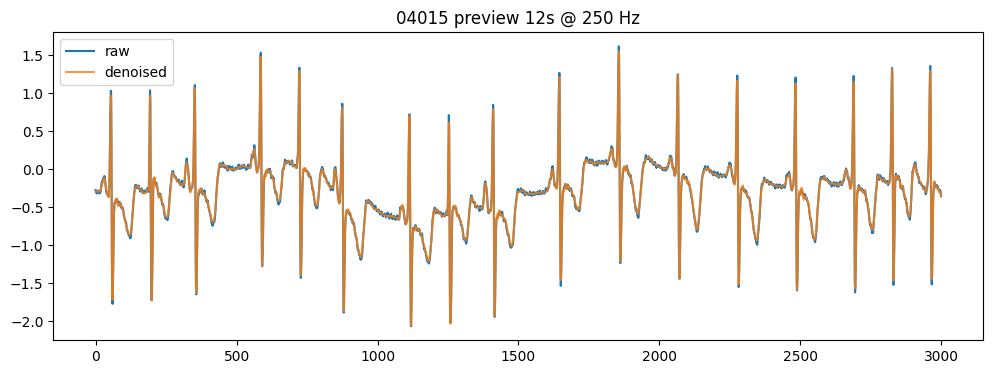

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def denoise(signal, wavelet='db6', level=None):
    """
    Wavelet denoise with universal threshold, auto level.
    Works at 250 Hz (AFDB) and adapts to signal length.
    """
    w = pywt.Wavelet(wavelet)
    max_level = pywt.dwt_max_level(len(signal), w.dec_len)
    if level is None:
        # cap to something stable; level 6–8 is typical for ECG lengths
        level = min(max_level, 7)
    coeffs = pywt.wavedec(signal, wavelet=w, level=level)

    # Universal threshold on detail coeffs (noise ~ cD1)
    # robust sigma estimate via median absolute deviation of the finest scale
    cD1 = coeffs[-1]
    sigma = np.median(np.abs(cD1)) / 0.6745 if len(cD1) else 0.0
    uthr = sigma * np.sqrt(2 * np.log(len(signal)))

    # Soft-threshold all detail levels; keep approx as-is
    coeffs[1:] = [pywt.threshold(c, value=uthr, mode='soft') for c in coeffs[1:]]
    rec = pywt.waverec(coeffs, wavelet=w)

    # length can drift by a few samples after waverec
    if len(rec) > len(signal):
        rec = rec[:len(signal)]
    return rec

# ---- Load a short window from your AFDB record (use the patient_id you loaded in Part A)
fs = int(info['fs'])  # from your earlier rdsamp
win_sec = 12
sig_win = lead0[patient_id][:int(fs*win_sec)]  # preview

# Plot raw vs denoised preview
rdata = denoise(sig_win, wavelet='db6')
plt.figure(figsize=(12,4))
plt.plot(sig_win, label='raw')
plt.plot(rdata, alpha=0.8, label='denoised')
plt.title(f'{patient_id} preview {win_sec}s @ {fs} Hz')
plt.legend()
plt.show()

### **B2: R-Peak Detection**




Replace your annotation-based R-peak code with XQRS detection

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Detected 17 R-peaks in 12.0s


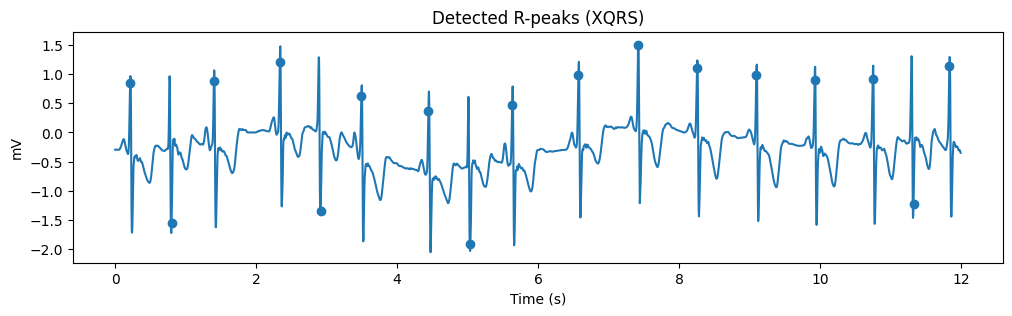

First few rhythm changes: [(np.int64(30), np.str_('(N')), (np.int64(102584), np.str_('(AFIB')), (np.int64(119604), np.str_('(N')), (np.int64(121773), np.str_('(AFIB')), (np.int64(122194), np.str_('(N'))]


In [ ]:
from wfdb import processing

# Use the denoised preview or a longer slice if you want
sig_for_qrs = np.asarray(rdata, dtype=float).ravel()
sig_for_qrs = np.nan_to_num(sig_for_qrs, nan=0.0)

# XQRS detection (fs-aware)
rpeaks = processing.xqrs_detect(sig=sig_for_qrs, fs=fs)

print(f"Detected {len(rpeaks)} R-peaks in {len(sig_for_qrs)/fs:.1f}s")
# Quick plot
plt.figure(figsize=(12,3))
t = np.arange(len(sig_for_qrs))/fs
plt.plot(t, sig_for_qrs)
plt.scatter(rpeaks/fs, sig_for_qrs[rpeaks], marker='o')
plt.title('Detected R-peaks (XQRS)')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.show()

# --- AFDB rhythm annotations (optional, for AF labeling later) ---
# These are NOT beat labels; they’re rhythm change points. Useful in Part C.
ann = wfdb.rdann(osj(DATA_ROOT, patient_id), 'atr')
rhythm_change_samples = np.asarray(ann.sample)
rhythm_labels = np.array([x.decode() if isinstance(x, bytes) else x for x in ann.aux_note])
print("First few rhythm changes:", list(zip(rhythm_change_samples[:5], rhythm_labels[:5])))

### **B3: Segmentation**
Each ECG signal is segmented by using a window **length of 300**. From R-peak location, **99** samples taken from **left** and **201** samples from **right**. Thus a complete **heartbeat** is found.

beat shape: (225,)
beat shape: (225,)
beat shape: (225,)


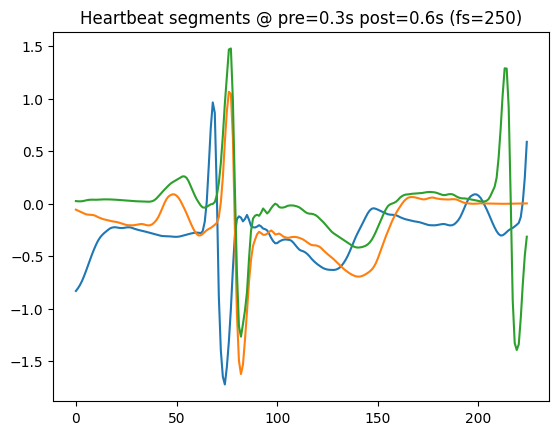

In [ ]:
# Time-based heartbeat window around each R-peak
pre_s, post_s = 0.30, 0.60
pre_samp, post_samp = int(pre_s*fs), int(post_s*fs)

valid = (rpeaks >= pre_samp) & (rpeaks + post_samp <= len(sig_for_qrs))
rpeaks_valid = rpeaks[valid]

k = np.arange(min(3, len(rpeaks_valid)))
for i in k:
    rp = rpeaks_valid[i]
    left, right = rp - pre_samp, rp + post_samp
    beat = sig_for_qrs[left:right]
    plt.plot(beat)
    print("beat shape:", beat.shape)
plt.title(f'Heartbeat segments @ pre={pre_s}s post={post_s}s (fs={fs})')
plt.show()

### **B4: Complete Preprocessing Figures**
The complete preprocessing including denosinsing, R-peak location detection and segmentation is expected to view in a single figure.

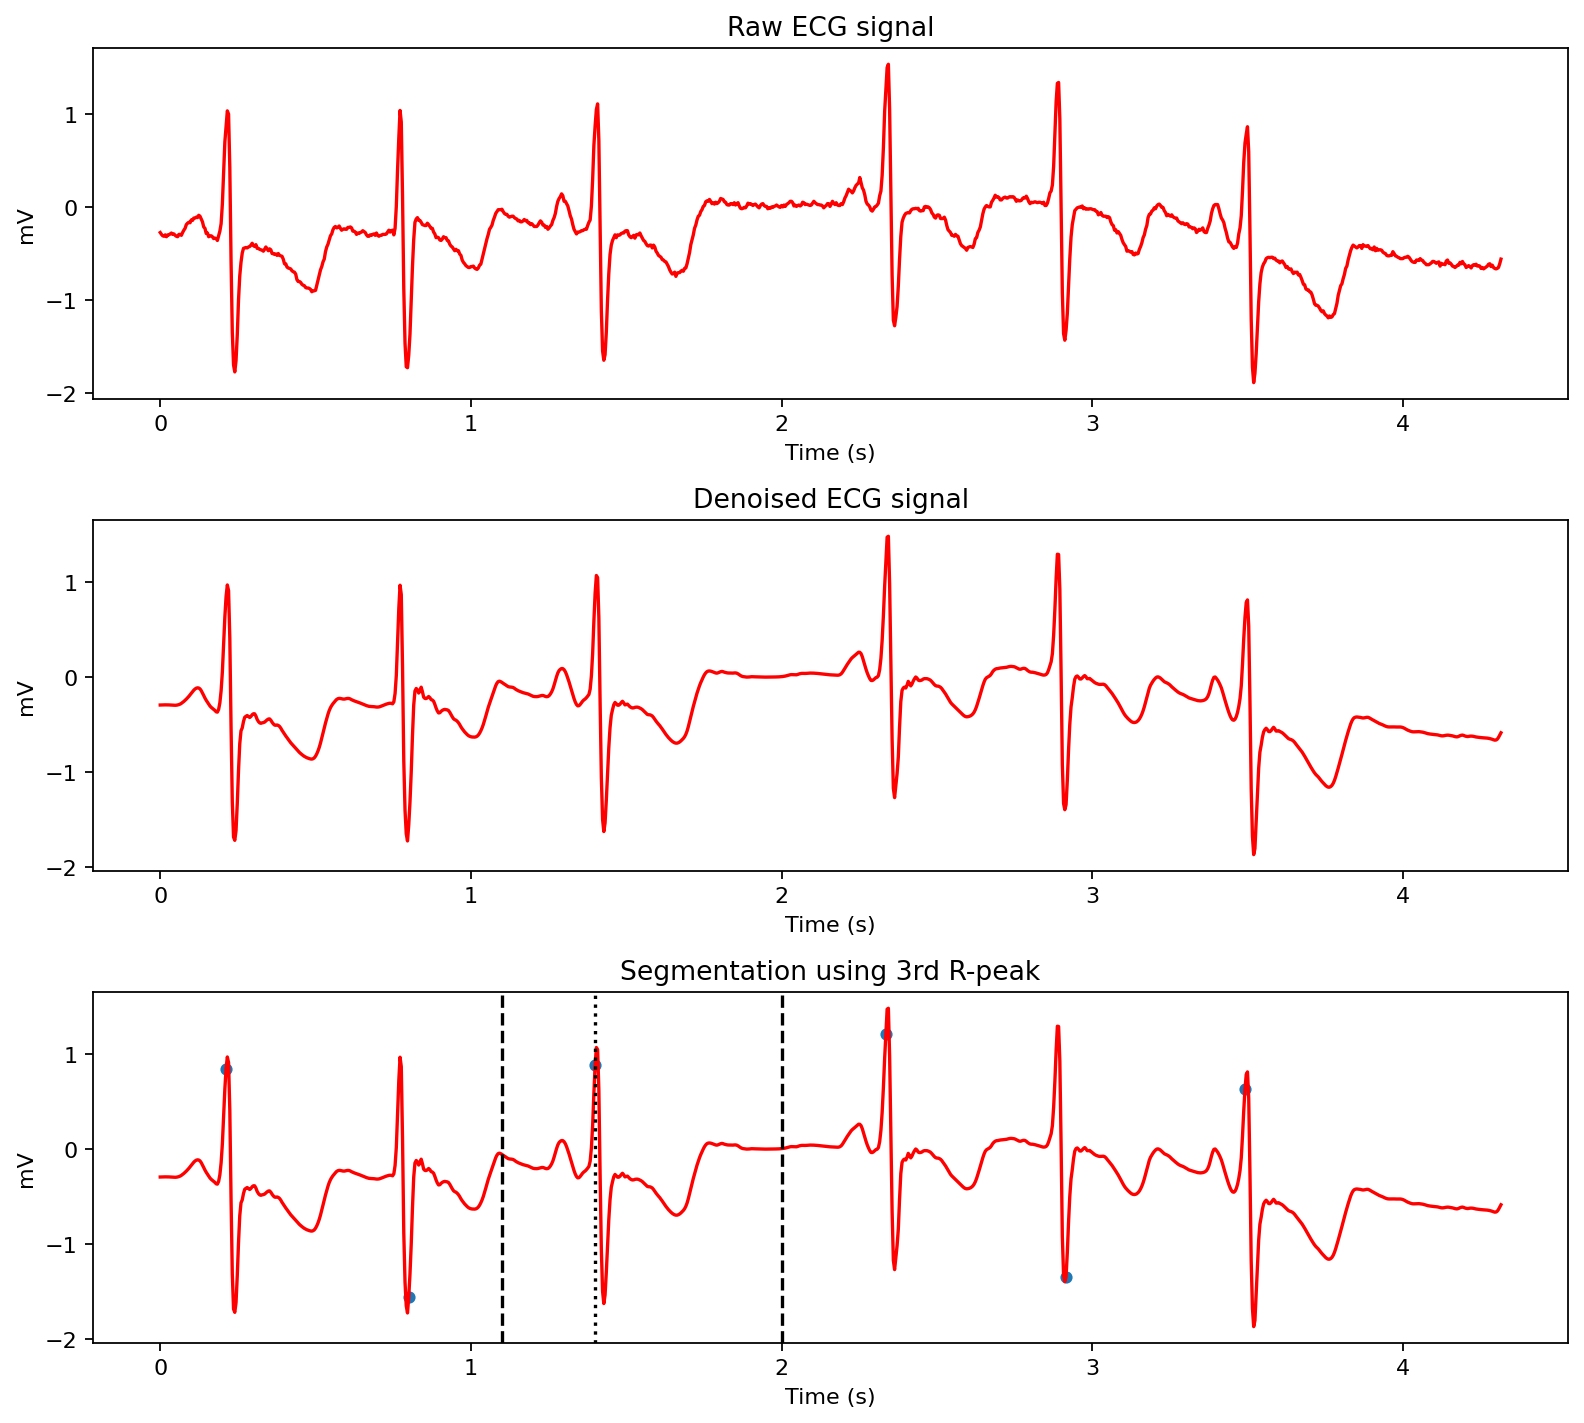

In [ ]:
# Choose a short slice for visualization (~4.3s = 1080 samples @ 250Hz)
viz_samples = int(min(len(sig_for_qrs), 1080))
x_time = np.arange(viz_samples) / fs

# Raw vs denoised comparison on the same window
raw_slice = sig_win[:viz_samples]
den_slice = rdata[:viz_samples]

plt.figure(figsize=(10,9), dpi=160)

# 1) Raw
plt.subplot(3,1,1)
plt.plot(x_time, raw_slice, color='red')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title('Raw ECG signal')

# 2) Denoised
plt.subplot(3,1,2)
plt.plot(x_time, den_slice, color='red')
plt.title('Denoised ECG signal')
plt.xlabel('Time (s)')
plt.ylabel('mV')

# 3) R-peaks + segmentation lines on denoised
plt.subplot(3,1,3)
# limit peaks to viz window
r_in = rpeaks[rpeaks < viz_samples]
plt.plot(x_time, den_slice, color='red')
plt.scatter(r_in/fs, den_slice[r_in], s=20)

# pick e.g., 3rd visible R-peak if exists
if len(r_in) >= 3:
    rp = r_in[2]
    left = max(0, rp - pre_samp)
    right = min(viz_samples, rp + post_samp)
    # vertical lines at rp, left, right
    plt.axvline(rp/fs, color='k', linestyle=':')
    plt.axvline(left/fs, color='k', linestyle='--')
    plt.axvline(right/fs, color='k', linestyle='--')
    plt.title('Segmentation using 3rd R-peak')
else:
    plt.title('Segmentation (not enough peaks in view)')

plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.tight_layout()
plt.show()

# **Part C: Dataset Loading**

## **C1: Loading whole data**

In [ ]:
# -------- Part C (updated, fast) --------
import wfdb
import numpy as np
import pandas as pd
from os.path import join as osj

# --------- Config (tweak as needed) ----------
WINDOW_SEC   = 8.0        # window length in seconds
STEP_SEC     = 4.0        # stride in seconds (50% overlap)
CHANNEL      = 0          # which channel to use
DENOISE      = False      # True uses your Part B denoise(); False is much faster
BALANCE_NEG  = 1.0        # keep up to 1x as many non-AF as AF (None to keep all)
TARGET_LABEL = "AFIB"     # AF label substring to match in rhythm annotations

# Speed caps for quick debugging (set to None to process all)
MAX_RECORDS = 3                 # only first N records; None = all
MAX_MINUTES_PER_RECORD = 2      # only first N minutes per record; None = full record
# ---------------------------------------------

def _clean_rhythm_label(lbl) -> str:
    """Decode bytes, strip parentheses/space, uppercase."""
    if isinstance(lbl, bytes):
        lbl = lbl.decode()
    return lbl.strip().strip('()').upper()

def get_rhythm_intervals(record_id: str):
    """
    Build contiguous rhythm intervals from AFDB annotations.
    Returns: list of (start_sample, end_sample, label) with label cleaned.
    """
    ann = wfdb.rdann(osj(DATA_ROOT, record_id), 'atr')
    change_pts = np.asarray(ann.sample, dtype=int)
    labels_raw = np.asarray(ann.aux_note, dtype=object)
    labels = np.array([_clean_rhythm_label(x) for x in labels_raw])

    hdr = wfdb.rdheader(osj(DATA_ROOT, record_id))
    total_len = int(hdr.sig_len)

    if change_pts.size == 0:
        return [(0, total_len, "UNKNOWN")]

    # Build [start, end) from change points
    starts = np.concatenate([change_pts, [total_len]])
    intervals = []
    for i in range(len(change_pts)):
        s = int(starts[i]); e = int(starts[i+1])
        lab = labels[i] if i < len(labels) else "UNKNOWN"
        if e > s:
            intervals.append((s, e, lab))
    if intervals and intervals[0][0] > 0:
        intervals = [(0, intervals[0][0], "UNKNOWN")] + intervals
    return intervals

def label_windows_from_intervals(total_len, fs, intervals, window_sec, step_sec, target="AFIB"):
    """
    Generate sliding window start/end indices and labels (1=AF, 0=non-AF).
    A window is AF if it overlaps any interval whose label contains `target`.
    """
    target = target.upper()
    W = int(round(window_sec * fs))
    S = int(round(step_sec * fs))
    if W <= 0 or S <= 0:
        raise ValueError("WINDOW_SEC and STEP_SEC must be > 0")

    af_intervals = [(s, e) for (s, e, lab) in intervals if target in lab]

    starts = list(range(0, max(0, total_len - W + 1), S))
    win_idx, labels = [], []

    for st in starts:
        en = st + W
        is_af = 0
        for (a, b) in af_intervals:
            if not (en <= a or st >= b):   # overlap
                is_af = 1
                break
        win_idx.append((st, en))
        labels.append(is_af)

    return win_idx, np.array(labels, dtype=int)

def load_afdb_windows(record_ids,
                      window_sec=WINDOW_SEC,
                      step_sec=STEP_SEC,
                      channel=CHANNEL,
                      denoise_flag=DENOISE,
                      target_label=TARGET_LABEL,
                      balance_neg=BALANCE_NEG):
    """
    Builds X (n_windows, W) and y (n_windows,) with 1=AF, 0=non-AF.
    Fast path: read each record ONCE, (optionally) denoise once, slice windows in RAM.
    """
    X_list, y_list, rid_list = [], [], []

    for rid_i, rid in enumerate(record_ids):
        # Optional cap: number of records
        if MAX_RECORDS is not None and rid_i >= MAX_RECORDS:
            break

        # Header (fs, total length)
        hdr = wfdb.rdheader(osj(DATA_ROOT, rid))
        fs = int(hdr.fs)
        total_len = int(hdr.sig_len)

        # Optional cap: duration per record
        if MAX_MINUTES_PER_RECORD is not None:
            total_len = min(total_len, int(MAX_MINUTES_PER_RECORD * 60 * fs))

        # Intervals and clip to total_len cap
        intervals = get_rhythm_intervals(rid)
        intervals = [(max(0, s), min(total_len, e), lab) for (s, e, lab) in intervals if s < total_len]

        # Window indices + labels
        win_idx, labels = label_windows_from_intervals(total_len, fs, intervals,
                                                       window_sec, step_sec,
                                                       target=target_label)

        # Optional class balancing: downsample non-AF relative to AF
        keep_mask = np.ones_like(labels, dtype=bool)
        if balance_neg is not None:
            af_idx = np.where(labels == 1)[0]
            naf_idx = np.where(labels == 0)[0]
            if len(af_idx) > 0 and len(naf_idx) > 0:
                max_non_af = int(np.ceil(balance_neg * len(af_idx)))
                if len(naf_idx) > max_non_af:
                    rng = np.random.default_rng(42)
                    keep_non_af = rng.choice(naf_idx, size=max_non_af, replace=False)
                    mask_non_af = np.zeros_like(labels, dtype=bool)
                    mask_non_af[keep_non_af] = True
                    keep_mask = (labels == 1) | mask_non_af

        # ---- FAST PATH: read the channel once, then slice all windows ----
        sig_all, _ = wfdb.rdsamp(osj(DATA_ROOT, rid), sampfrom=0, sampto=total_len)
        ch = min(channel, sig_all.shape[1] - 1)
        x_all = np.asarray(sig_all[:, ch], dtype=np.float32).ravel()

        if denoise_flag:
            x_all = denoise(x_all)  # from Part B

        W = int(round(window_sec * fs))
        for (st, en), lab, keep in zip(win_idx, labels, keep_mask):
            if not keep:
                continue
            x = x_all[st:en]
            # pad/trim to exact length
            if len(x) < W:
                x = np.pad(x, (0, W - len(x)))
            elif len(x) > W:
                x = x[:W]
            X_list.append(x.astype(np.float32))
            y_list.append(int(lab))
            rid_list.append(rid)

        kept = keep_mask.nonzero()[0]
        lab_kept = labels[keep_mask] if kept.size else np.array([], dtype=int)
        n_kept = kept.size
        n_af = int(lab_kept.sum()) if lab_kept.size else 0
        n_non = n_kept - n_af
        print(f"{rid}: windows kept={n_kept} (AF={n_af}, nonAF={n_non})")

    X = np.stack(X_list, axis=0) if X_list else np.empty((0, 0), dtype=np.float32)
    y = np.array(y_list, dtype=int)
    rids = np.array(rid_list, dtype=object)
    return X, y, rids

# -------- Run loader over discovered AFDB records (from Part A) -------
np.random.seed(42)
record_ids = patient_ids  # from Part A discovery
X, Y, rec_ids = load_afdb_windows(record_ids=record_ids)

print("X shape:", X.shape)        # (n_windows, W)
print("Y distribution:", dict(zip(*np.unique(Y, return_counts=True))))
print("Unique records:", len(np.unique(rec_ids)))

04015: windows kept=29 (AF=0, nonAF=29)
04043: windows kept=29 (AF=0, nonAF=29)
04048: windows kept=29 (AF=0, nonAF=29)
X shape: (87, 2000)
Y distribution: {np.int64(0): np.int64(87)}
Unique records: 3


## **C2: Ploting 15 Different Heartbeats**

No windows with label=1.


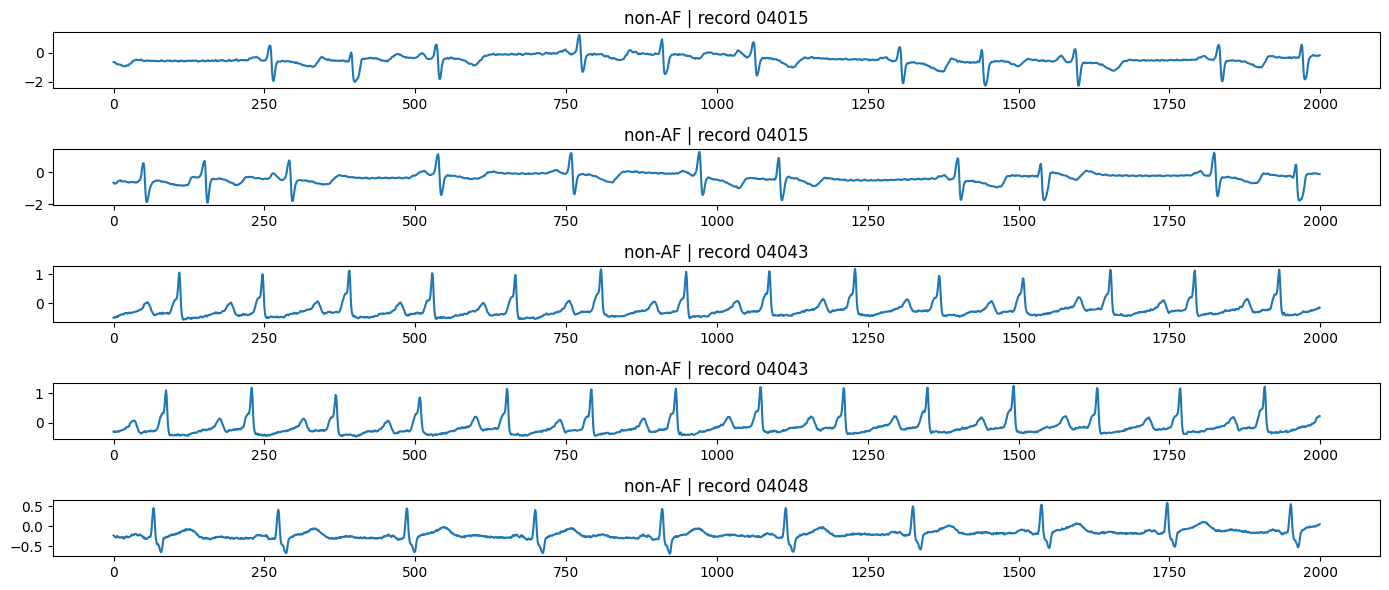

In [ ]:
# Make a DataFrame for convenience (each row is a window)
df_X = pd.DataFrame(X)
df_Y = pd.Series(Y, name='label')  # 1=AF, 0=non-AF
df_REC = pd.Series(rec_ids, name='record')

def plot_random_windows(label=1, num=5):
    """
    Plot `num` random windows for the given label (1=AF, 0=non-AF).
    """
    idx = np.where(Y == label)[0]
    if len(idx) == 0:
        print(f"No windows with label={label}.")
        return
    if num > len(idx):
        print(f"Only {len(idx)} windows available for label={label}; plotting all.")
        num = len(idx)
    rng = np.random.default_rng(234)
    pick = rng.choice(idx, size=num, replace=False)

    plt.figure(figsize=(14, 6))
    for i, p in enumerate(pick, 1):
        plt.subplot(num, 1, i)
        plt.plot(df_X.iloc[p].values)
        rec = df_REC.iloc[p]
        plt.title(f"{'AF' if label==1 else 'non-AF'} | record {rec}")
        plt.tight_layout()
    plt.show()

# Examples:
plot_random_windows(label=1, num=5)  # AF windows
plot_random_windows(label=0, num=5)  # non-AF windows

# **Part D: Train-Test Splitting and Class Balancing**

In [ ]:
print("TRAIN:", dict(zip(*np.unique(y_train, return_counts=True))))
print("VAL  :", dict(zip(*np.unique(y_val,   return_counts=True))))
print("TEST :", dict(zip(*np.unique(y_test,  return_counts=True))))

NameError: name 'y_train' is not defined

In [ ]:
# --- Find AF records, rebuild windows with AF present, then sanity-check splits ---

import numpy as np, pandas as pd, wfdb
from os.path import join as osj

# 1) helper to clean labels (same as Part C)
def _clean(lbl):
    if isinstance(lbl, bytes):
        lbl = lbl.decode()
    return lbl.strip().strip('()').upper()

def record_has_af(rid):
    ann = wfdb.rdann(osj(DATA_ROOT, rid), 'atr')
    labels = [_clean(x) for x in ann.aux_note]
    return any('AFIB' in l for l in labels)

# 2) list AF / non-AF records from your discovered patient_ids
af_recs    = [rid for rid in patient_ids if record_has_af(rid)]
nonaf_recs = [rid for rid in patient_ids if rid not in af_recs]

print("AF records found:", af_recs[:10], "(+ more)" if len(af_recs)>10 else "")
print("Non-AF records (first 10):", nonaf_recs[:10])

# 3) (Re)build windows focusing on AF records (+ a few non-AF for negatives)
#    Adjust these knobs to taste:
USE_AF_RECORDS      = af_recs[:6]           # use up to 6 AF records
USE_NONAF_RECORDS   = nonaf_recs[:4]        # add a few non-AF for contrast
RECORDS_FOR_DATASET = USE_AF_RECORDS + USE_NONAF_RECORDS

# Make sure your Part C loader is in scope: load_afdb_windows(...)
# Also make sure you haven't capped MAX_RECORDS / MAX_MINUTES_PER_RECORD too low.
# For real coverage, do:
MAX_RECORDS = None
MAX_MINUTES_PER_RECORD = None
DENOISE = False  # faster while iterating

X, Y, rec_ids = load_afdb_windows(
    record_ids=RECORDS_FOR_DATASET,
    window_sec=WINDOW_SEC, step_sec=STEP_SEC,
    channel=CHANNEL, denoise_flag=DENOISE,
    target_label=TARGET_LABEL, balance_neg=BALANCE_NEG
)

print("NEW windows:", X.shape, "| Label dist:", dict(zip(*np.unique(Y, return_counts=True))))
print("Records used:", sorted(set(rec_ids.tolist())))

# 4) sanity-check per-record AF counts (helps debugging)
df_chk = pd.DataFrame({'rid': rec_ids, 'y': Y})
tbl = df_chk.groupby('rid')['y'].value_counts().unstack(fill_value=0)
print("\nPer-record counts (cols: 0=non-AF, 1=AF):")
print(tbl)

# 5) overwrite the globals used by Part D/E/F
X_win = X
y_win = Y.astype('int64')
groups = rec_ids

# quick check
print("\nReady for Part D. Overall:", dict(zip(*np.unique(y_win, return_counts=True))))

AF records found: ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261'] (+ more)
Non-AF records (first 10): []
04015: windows kept=146 (AF=73, nonAF=73)
04043: windows kept=4286 (AF=2143, nonAF=2143)
04048: windows kept=210 (AF=105, nonAF=105)
04126: windows kept=716 (AF=358, nonAF=358)
04746: windows kept=9204 (AF=4898, nonAF=4306)
04908: windows kept=1572 (AF=786, nonAF=786)
NEW windows: (16134, 2000) | Label dist: {np.int64(0): np.int64(7771), np.int64(1): np.int64(8363)}
Records used: ['04015', '04043', '04048', '04126', '04746', '04908']

Per-record counts (cols: 0=non-AF, 1=AF):
y         0     1
rid              
04015    73    73
04043  2143  2143
04048   105   105
04126   358   358
04746  4306  4898
04908   786   786

Ready for Part D. Overall: {np.int64(0): np.int64(7771), np.int64(1): np.int64(8363)}


In [ ]:
# === Part D: Group-aware Train/Val/Test + robust balancing (AFDB windows) ===
import os
import numpy as np
import pandas as pd
from os.path import join as osj
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import SMOTE

# --- Inputs from Part C ---
# X, Y, rec_ids, project_path must already exist
X_win = X                    # (n_windows, W)
y_win = Y.astype("int64")    # 0 = non-AF, 1 = AF
groups = rec_ids             # record id per window

print("Windows:", X_win.shape,
      "| Unique records:", len(np.unique(groups)),
      "| Label distribution:", dict(zip(*np.unique(y_win, return_counts=True))))

# ---------- helpers ----------
def split_group_aware(X, y, g, test_size=0.20, seed=42, retries=30, need_both_classes=True, name="test"):
    """
    Group-aware split. Tries multiple seeds to ensure both classes appear in both folds (if requested).
    Returns: X_tr, y_tr, g_tr, X_te, y_te, g_te
    """
    last = None
    for k in range(retries):
        rs = seed + k
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
        tr_idx, te_idx = next(gss.split(X, y, g))
        X_tr, y_tr, g_tr = X[tr_idx], y[tr_idx], g[tr_idx]
        X_te, y_te, g_te = X[te_idx], y[te_idx], g[te_idx]
        last = (X_tr, y_tr, g_tr, X_te, y_te, g_te, rs)

        if not need_both_classes:
            print(f"{name.title()} split (no class check) seed={rs}")
            return X_tr, y_tr, g_tr, X_te, y_te, g_te

        ok_tr = np.unique(y_tr).size >= 2
        ok_te = np.unique(y_te).size >= 2
        if ok_tr and ok_te:
            print(f"{name.title()} split OK with seed={rs}")
            return X_tr, y_tr, g_tr, X_te, y_te, g_te

    # Fallback if we never got both classes
    print(f"⚠️ Could not get both classes in {name} after {retries} tries. Using last seed={last[-1]}.")
    X_tr, y_tr, g_tr, X_te, y_te, g_te, _ = last
    return X_tr, y_tr, g_tr, X_te, y_te, g_te

def maybe_smote(X_tr_raw, y_tr_raw, random_state=42):
    """Apply SMOTE only if there are 2 classes and minority has ≥2 samples."""
    classes, counts = np.unique(y_tr_raw, return_counts=True)
    if classes.size < 2:
        print("Skipping SMOTE: train fold has one class.")
        return X_tr_raw, y_tr_raw
    if counts.min() < 2:
        print("Skipping SMOTE: minority class has < 2 samples.")
        return X_tr_raw, y_tr_raw
    sm = SMOTE(sampling_strategy="auto", random_state=random_state)
    Xb, yb = sm.fit_resample(X_tr_raw, y_tr_raw)
    print("After SMOTE train counts:", dict(zip(*np.unique(yb, return_counts=True))))
    return Xb, yb

def per_record_counts(y, g, title):
    df = pd.DataFrame({"rid": g, "y": y})
    tab = df.groupby("rid")["y"].value_counts().unstack(fill_value=0).sort_index()
    print(f"\n{title} — per-record counts (cols: 0=non-AF, 1=AF)")
    print(tab)

# ---------- require both classes if present globally ----------
need_both_classes = (np.unique(y_win).size >= 2)

# 1) Group-aware TRAIN/TEST
X_train_full, y_train_full, groups_train, X_test, y_test, groups_test = split_group_aware(
    X_win, y_win, groups, test_size=0.20, seed=42, retries=40,
    need_both_classes=need_both_classes, name="test"
)

print("\nTrain/Test sizes:", X_train_full.shape, X_test.shape)
print("Train counts:", dict(zip(*np.unique(y_train_full, return_counts=True))))
print("Test  counts:", dict(zip(*np.unique(y_test,       return_counts=True))))
print("#Train records:", len(np.unique(groups_train)), "| #Test records:", len(np.unique(groups_test)))

per_record_counts(y_train_full, groups_train, "TRAIN(full)")
per_record_counts(y_test,       groups_test,  "TEST")

# Save held-out TEST set
try:
    test_path = osj(project_path, "test_windows.pkl")
    pd.DataFrame(np.hstack([X_test, y_test[:, None]])).to_pickle(test_path)
    print("Saved test set ->", test_path)
except Exception as e:
    print("Skip saving test_windows.pkl:", e)

# # 2) Group-aware TRAIN/VAL from TRAIN
# X_tr_raw, y_tr_raw, groups_tr, X_val, y_val, groups_va = split_group_aware(
#     X_train_full, y_train_full, groups_train, test_size=0.15, seed=123, retries=40,
#     need_both_classes=need_both_classes, name="val"
# )

# print("\nPre-balance TRAIN/VAL:", X_tr_raw.shape, X_val.shape)
# print("Train(raw) counts:", dict(zip(*np.unique(y_tr_raw, return_counts=True))))
# print("Val counts:",        dict(zip(*np.unique(y_val,    return_counts=True))))
# per_record_counts(y_tr_raw, groups_tr, "TRAIN(raw)")
# per_record_counts(y_val,    groups_va, "VAL")

# 2) Group-aware TRAIN/VAL from TRAIN with at least 2 validation groups
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

def split_group_aware_min_groups(X, y, g, test_size=0.15, seed=123, retries=60, min_val_groups=2):
    last = None
    for k in range(retries):
        rs = seed + k
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
        tr_idx, va_idx = next(gss.split(X, y, g))
        g_va = np.unique(g[va_idx])
        if g_va.size >= min_val_groups:
          return tr_idx, va_idx, rs
        last = (tr_idx, va_idx, rs)
    print(f"Warning: kept last seed={last[-1]} with {np.unique(g[last[1]]).size} val groups.")
    return last

tr_idx, val_idx, used_seed = split_group_aware_min_groups(
    X_train_full, y_train_full, groups_train, test_size=0.15, seed=123, min_val_groups=2
)

X_tr_raw, y_tr_raw, groups_tr = X_train_full[tr_idx], y_train_full[tr_idx], groups_train[tr_idx]
X_val,     y_val,    groups_va = X_train_full[val_idx], y_train_full[val_idx], groups_train[val_idx]
print("VAL groups:", np.unique(groups_va))

per_record_counts(y_tr_raw, groups_tr, "TRAIN(raw)")
per_record_counts(y_val,    groups_va, "VAL")

# 3) Balance ONLY the TRAIN fold (conditional SMOTE)
# We already have plenty of both classes; skip SMOTE to keep signals real.
X_train, y_train = X_tr_raw, y_tr_raw

# 4) Add channel dimension for 1D CNNs: (N, W, 1)
X_train = X_train[..., None]
X_val   = X_val[..., None]
X_test  = X_test[..., None]

print("\nShapes -> Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)
print("Final Train/Val/Test counts:",
      dict(zip(*np.unique(y_train, return_counts=True))),
      dict(zip(*np.unique(y_val,   return_counts=True))),
      dict(zip(*np.unique(y_test,  return_counts=True))))

Windows: (16134, 2000) | Unique records: 6 | Label distribution: {np.int64(0): np.int64(7771), np.int64(1): np.int64(8363)}
Test split OK with seed=42

Train/Test sizes: (11702, 2000) (4432, 2000)
Train counts: {np.int64(0): np.int64(5555), np.int64(1): np.int64(6147)}
Test  counts: {np.int64(0): np.int64(2216), np.int64(1): np.int64(2216)}
#Train records: 4 | #Test records: 2

TRAIN(full) — per-record counts (cols: 0=non-AF, 1=AF)
y         0     1
rid              
04048   105   105
04126   358   358
04746  4306  4898
04908   786   786

TEST — per-record counts (cols: 0=non-AF, 1=AF)
y         0     1
rid              
04015    73    73
04043  2143  2143
Saved test set -> /content/drive/MyDrive/files/test_windows.pkl
VAL groups: ['04048']

TRAIN(raw) — per-record counts (cols: 0=non-AF, 1=AF)
y         0     1
rid              
04126   358   358
04746  4306  4898
04908   786   786

VAL — per-record counts (cols: 0=non-AF, 1=AF)
y        0    1
rid            
04048  105  105

Shapes 

Preprocessing

In [ ]:
# --- Baseline removal (high-pass) + per-window z-score normalization ---
import numpy as np
from scipy.signal import butter, filtfilt

def highpass(x, fs=250, fc=0.5, order=3):
    b, a = butter(order, fc/(fs/2), btype='high')
    # x is (N, W, 1). Filter along time axis (-2)
    x = filtfilt(b, a, x, axis=-2)
    return x

def zscore_per_window(X, eps=1e-6):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + eps
    return (X - mu) / sd

FS = 250  # AFDB fs

X_train = highpass(X_train, fs=FS, fc=0.5)
X_val   = highpass(X_val,   fs=FS, fc=0.5)
X_test  = highpass(X_test,  fs=FS, fc=0.5)

X_train = zscore_per_window(X_train)
X_val   = zscore_per_window(X_val)
X_test  = zscore_per_window(X_test)

# **Part E: Model Building and Training**
A **CNN-LSTM and attention** based hybrid model is formulated.

## **E2: CNN-LSTM and attention model architecture**

In [ ]:
# --- Hybrid model: multi-scale CNN → SE → 2×Transformer → BiGRU + attention → sigmoid ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd

def conv_bn_relu(x, f, k, s=1, d=1):
    x = layers.Conv1D(f, k, strides=s, padding="same", dilation_rate=d, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def se_block(x, r=16):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D()(x)
    s = layers.Dense(max(c//r, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    return layers.Multiply()([x, layers.Reshape((1,c))(s)])

def multi_scale_stem(x, nf=32):
    b1 = conv_bn_relu(x, nf, 3)
    b2 = conv_bn_relu(x, nf, 7)
    b3 = conv_bn_relu(x, nf, 15)
    x  = layers.Concatenate()([b1,b2,b3])
    x  = conv_bn_relu(x, nf*3, 1)
    return x

def transformer_encoder(x, d_model=128, num_heads=4, mlp_ratio=2.0, drop=0.1):
    if x.shape[-1] != d_model:
        x = layers.Conv1D(d_model, 1, padding="same")(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=drop)(x, x)
    x = layers.Add()([x, attn]); x = layers.LayerNormalization()(x)
    y = layers.Conv1D(int(d_model*mlp_ratio), 1, activation="relu")(x)
    y = layers.Dropout(drop)(y)
    y = layers.Conv1D(d_model, 1)(y)
    x = layers.Add()([x, y]); x = layers.LayerNormalization()(x)
    return x

def attention_pooling(x, units=128):
    # Keras-3-safe attention pooling (no raw tf ops)
    score = layers.Dense(units, activation="tanh")(x)  # (N,T,units)
    score = layers.Dense(1)(score)                    # (N,T,1)
    w = layers.Softmax(axis=1)(score)                 # softmax over time
    xw = layers.Multiply()([x, w])                    # (N,T,C)
    # Use keras.ops.sum via Lambda to avoid tf.reduce_sum on KerasTensor
    ctx = layers.Lambda(lambda t: keras.ops.sum(t, axis=1))(xw)  # (N,C)
    return ctx

def build_hybrid(seq_shape, d_model=128, heads=4, gru_units=96, drop=0.2):
    inp = keras.Input(shape=seq_shape)  # (W,1)
    x = multi_scale_stem(inp, nf=32)
    x = conv_bn_relu(x, 96, 5);  x = layers.MaxPooling1D(2)(x);  x = layers.Dropout(0.1)(x)
    x = conv_bn_relu(x, 128,5);  x = layers.MaxPooling1D(2)(x);  x = layers.Dropout(0.1)(x)
    x = se_block(x)
    for _ in range(2):
        x = transformer_encoder(x, d_model=d_model, num_heads=heads, mlp_ratio=2.0, drop=0.1)
    x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.2))(x)
    x = attention_pooling(x, units=128)
    x = layers.Dropout(drop)(x)
    out = layers.Dense(1, activation="sigmoid")(x)  # binary head
    model = keras.Model(inp, out, name="Hybrid_SETrans_BiGRU_Attn")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="rec")]
    )
    return model

hybrid = build_hybrid(seq_shape=X_train.shape[1:])
hybrid.summary()

cb = [
    keras.callbacks.ModelCheckpoint("best_Hybrid.keras", save_best_only=True, monitor="val_auc", mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", patience=4, factor=0.5, min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True),
]

hist_h = hybrid.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25, batch_size=256,
    callbacks=cb, verbose=2
)

# Threshold tuning for F1 on VAL
val_prob = hybrid.predict(X_val, verbose=0).ravel()
ths = np.linspace(0.2, 0.8, 61)
f1s = [f1_score(y_val, (val_prob >= t).astype(int)) for t in ths]
best_t = float(ths[int(np.argmax(f1s))])
print("Best threshold on VAL for F1:", best_t, "F1=", float(np.max(f1s)))

# Test metrics at tuned threshold
test_prob = hybrid.predict(X_test, verbose=0).ravel()
test_hat  = (test_prob >= best_t).astype(int)

acc  = float((test_hat == y_test).mean())
f1m  = float(f1_score(y_test, test_hat, average="macro", zero_division=0))
prec = float(precision_score(y_test, test_hat, average="macro", zero_division=0))
rec  = float(recall_score(y_test, test_hat, average="macro", zero_division=0))
try:
    auroc = float(roc_auc_score(y_test, test_prob))
except Exception:
    auroc = float("nan")

print({"acc":acc, "f1_macro":f1m, "precision_macro":prec, "recall_macro":rec, "auroc":auroc})
pd.DataFrame(classification_report(y_test, test_hat, output_dict=True, zero_division=0)).T.to_csv("report_Hybrid.csv")
pd.DataFrame(confusion_matrix(y_test, test_hat)).to_csv("cm_Hybrid.csv", index=False)

Model: "Hybrid_SETrans_BiGRU_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_143 (Conv1D) │ (None, 2000, 32)  │         96 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_144 (Conv1D) │ (None, 2000, 32)  │        224 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_145 (Conv1D) │ (None, 2000, 32)  │        480 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_143[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_144[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_145[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_108 (ReLU)    │ (None, 2000, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_109 (ReLU)    │ (None, 2000, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_110 (ReLU)    │ (None, 2000, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 2000, 96)  │          0 │ re_lu_108[0][0],  │
│ (Concatenate)       │                   │            │ re_lu_109[0][0],  │
│                     │                   │            │ re_lu_110[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_146 (Conv1D) │ (None, 2000, 96)  │      9,216 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 96)  │        384 │ conv1d_146[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_111 (ReLU)    │ (None, 2000, 96)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_147 (Conv1D) │ (None, 2000, 96)  │     46,080 │ re_lu_111[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 96)  │        384 │ conv1d_147[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_112 (ReLU)    │ (None, 2000, 96)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 1000, 96)  │          0 │ re_lu_112[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 1000, 96)  │          0 │ max_pooling1d_24… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_148 (Conv1D) │ (None, 1000, 128) │     61,440 │ dropout_64[0][0]

 Total params: 541,546 (2.07 MB)

 Trainable params: 540,714 (2.06 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/25
45/45 - 55s - 1s/step - auc: 0.9008 - loss: 0.3914 - prec: 0.8149 - rec: 0.8136 - val_auc: 0.4627 - val_loss: 3.1123 - val_prec: 0.5075 - val_rec: 0.9619 - learning_rate: 1.0000e-03
Epoch 2/25
45/45 - 40s - 879ms/step - auc: 0.9949 - loss: 0.0919 - prec: 0.9627 - rec: 0.9659 - val_auc: 0.4630 - val_loss: 3.6231 - val_prec: 0.5098 - val_rec: 0.9905 - learning_rate: 1.0000e-03
Epoch 3/25
45/45 - 40s - 880ms/step - auc: 0.9975 - loss: 0.0575 - prec: 0.9821 - rec: 0.9811 - val_auc: 0.5333 - val_loss: 3.9428 - val_prec: 0.5024 - val_rec: 1.0000 - learning_rate: 1.0000e-03
Epoch 4/25
45/45 - 40s - 880ms/step - auc: 0.9981 - loss: 0.0377 - prec: 0.9899 - rec: 0.9891 - val_auc: 0.5435 - val_loss: 3.6963 - val_prec: 0.5072 - val_rec: 1.0000 - learning_rate: 1.0000e-03
Epoch 5/25
45/45 - 39s - 873ms/step - auc: 0.9992 - loss: 0.0246 - prec: 0.9924 - rec: 0.9911 - val_auc: 0.5288 - val_loss: 4.0452 - val_prec: 0.5072 - val_rec: 1.0000 - learning_rate: 1.0000e-03
Epoch 6/25
45/45 - 39s 

In [ ]:
import os, time, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix,
    precision_score, recall_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import pandas as pd
np.random.seed(42); tf.random.set_seed(42)

input_shape = X_train.shape[1:]         # (seq_len, 1)
num_classes = len(np.unique(y_train))

def common_tail(x, num_classes):
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    return layers.Dense(num_classes, activation="softmax")(x)

def compile_model(inputs, outputs, lr=1e-3):
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Model zoo ---

def build_cnn1d(filters=[32,64,128], kernel=7):
    inp = keras.Input(shape=input_shape)
    x = inp
    for f in filters:
        x = layers.Conv1D(f, kernel, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.2)(x)
    out = common_tail(x, num_classes)
    return compile_model(inp, out)

def build_lstm(units=128):
    inp = keras.Input(shape=input_shape)
    x = layers.LSTM(units, return_sequences=False)(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return compile_model(inp, out)

def build_bilstm(units=96):
    inp = keras.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(units))(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return compile_model(inp, out)

def build_gru(units=128):
    inp = keras.Input(shape=input_shape)
    x = layers.GRU(units)(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return compile_model(inp, out)

def build_bigru(units=96):
    inp = keras.Input(shape=input_shape)
    x = layers.Bidirectional(layers.GRU(units))(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return compile_model(inp, out)

# Simple TCN block (dilated causal conv residual stack)
def tcn_block(x, filters, kernel=3, dilation=1, dropout=0.2):
    y = layers.Conv1D(filters, kernel, padding="causal", dilation_rate=dilation)(x)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters, kernel, padding="causal", dilation_rate=dilation)(y)
    y = layers.BatchNormalization()(y)
    if x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, padding="same")(x)
    y = layers.Add()([x, y]); y = layers.ReLU()(y)
    return y

def build_tcn(filters=64, stacks=3, kernel=3):
    inp = keras.Input(shape=input_shape)
    x = inp
    for s in range(stacks):
        for d in [1, 2, 4, 8]:  # dilations
            x = tcn_block(x, filters, kernel, dilation=d)
    out = common_tail(x, num_classes)
    return compile_model(inp, out)

# ResNet1D-18 (1D adaptation)
def res_block_1d(x, f, stride=1):
    y = layers.Conv1D(f, 3, padding="same", strides=stride)(x)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.Conv1D(f, 3, padding="same")(y)
    y = layers.BatchNormalization()(y)
    if stride != 1 or x.shape[-1] != f:
        x = layers.Conv1D(f, 1, strides=stride, padding="same")(x)
        x = layers.BatchNormalization()(x)
    y = layers.Add()([x, y]); y = layers.ReLU()(y)
    return y

def build_resnet1d18():
    inp = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 7, strides=2, padding="same")(inp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding="same")(x)
    # layers: [2,2,2,2]
    for f, n, s in [(64,2,1),(128,2,2),(256,2,2),(512,2,2)]:
        for i in range(n):
            x = res_block_1d(x, f, stride=(s if i==0 else 1))
    out = common_tail(x, num_classes)
    return compile_model(inp, out)

# VGG1D-16 (stacked convs + pooling)
def vgg_block_1d(x, filters, convs=2):
    for _ in range(convs):
        x = layers.Conv1D(filters, 3, padding="same")(x)
        x = layers.ReLU()(x)
    return layers.MaxPooling1D(2)(x)

def build_vgg1d16():
    inp = keras.Input(shape=input_shape)
    x = inp
    x = vgg_block_1d(x, 64, 2)
    x = vgg_block_1d(x, 128, 2)
    x = vgg_block_1d(x, 256, 3)
    x = vgg_block_1d(x, 512, 3)
    x = vgg_block_1d(x, 512, 3)
    out = common_tail(x, num_classes)
    return compile_model(inp, out)

# InceptionTime (1D GoogLeNet-ish)
def inception_time_module(x, nb_filters=32):
    b1 = layers.Conv1D(nb_filters, 9, padding='same')(x)
    b2 = layers.Conv1D(nb_filters, 19, padding='same')(x)
    b3 = layers.Conv1D(nb_filters, 39, padding='same')(x)
    b4 = layers.MaxPooling1D(3, padding='same', strides=1)(x)
    b4 = layers.Conv1D(nb_filters, 1, padding='same')(b4)
    x = layers.Concatenate()([b1, b2, b3, b4])
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    return x

def build_inceptiontime(depth=6, nb_filters=32):
    inp = keras.Input(shape=input_shape)
    x = inp
    for _ in range(depth):
        x = inception_time_module(x, nb_filters)
    out = common_tail(x, num_classes)
    return compile_model(inp, out)

MODEL_ZOO = {
    "CNN1D": build_cnn1d,
    "LSTM": build_lstm,
    "BiLSTM": build_bilstm,
    "GRU": build_gru,
    "BiGRU": build_bigru,
    "TCN": build_tcn,
    "ResNet1D-18": build_resnet1d18,
    "VGG1D-16": build_vgg1d16,
    "InceptionTime": build_inceptiontime,  # stand-in for GoogLeNet style
}

# --- Callbacks & training loop ---

def callbacks(name):
    return [
        keras.callbacks.ModelCheckpoint(
            f"best_{name}.keras", save_best_only=True, monitor="val_accuracy", mode="max"
        ),
        keras.callbacks.ReduceLROnPlateau(
            patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(
            patience=10, restore_best_weights=True, monitor="val_accuracy", mode="max"
        ),
    ]

def compute_auroc(y_true, y_prob):
    """
    Returns AUROC:
    - Binary: uses positive-class probs y_prob[:, 1]
    - Multi-class: macro-averaged OvR AUROC
    If not computable (e.g., single class in test), returns np.nan.
    """
    try:
        C = y_prob.shape[1]
        if C == 2:
            # binary
            if len(np.unique(y_true)) < 2:
                return float("nan")
            return roc_auc_score(y_true, y_prob[:, 1])
        else:
            # multi-class macro OvR
            classes = np.arange(C)
            Yb = label_binarize(y_true, classes=classes)
            if Yb.shape[1] != C:
                return float("nan")
            return roc_auc_score(Yb, y_prob, average="macro", multi_class="ovr")
    except Exception:
        return float("nan")



results = []

for name, builder in MODEL_ZOO.items():
    print(f"\n=== Training {name} ===")
    model = builder()

    start = time.time()
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20, batch_size=128,
        callbacks=callbacks(name),
        verbose=2,
        class_weight=None  # set your class_weight dict if needed
    )
    train_time = time.time() - start

    # Evaluate
    # Evaluate
    y_prob = model.predict(X_test, verbose=0)
    y_hat  = np.argmax(y_prob, axis=1)

    # Core scores
    acc        = float((y_hat == y_test).mean())
    f1_macro   = float(f1_score(y_test, y_hat, average="macro", zero_division=0))
    prec_macro = float(precision_score(y_test, y_hat, average="macro", zero_division=0))
    rec_macro  = float(recall_score(y_test, y_hat, average="macro", zero_division=0))

    # AUROC (binary uses y_prob[:,1]; multi uses macro OvR)
    auroc = float(compute_auroc(y_test, y_prob))

    # Full report + CM (still saved to disk)
    report = classification_report(y_test, y_hat, output_dict=True, zero_division=0)
    cm     = confusion_matrix(y_test, y_hat)
    pd.DataFrame(cm).to_csv(f"cm_{name}.csv", index=False)
    pd.DataFrame(report).T.to_csv(f"report_{name}.csv")

    # Params
    params = model.count_params()

    # Collect
    results.append({
        "model": name,
        "params": params,
        "test_acc": acc,
        "test_f1_macro": f1_macro,
        "test_precision_macro": prec_macro,
        "test_recall_macro": rec_macro,
        "test_auroc": auroc,
        "train_time_sec": int(train_time),
        "best_ckpt": f"best_{name}.keras"
    })

df = pd.DataFrame(results).sort_values("test_f1_macro", ascending=False)
df.to_csv("results.csv", index=False)
df



=== Training ResNet1D-18 ===
Epoch 1/20
90/90 - 57s - 629ms/step - accuracy: 0.9471 - loss: 0.1848 - val_accuracy: 0.5000 - val_loss: 2.4413 - learning_rate: 1.0000e-03
Epoch 2/20
90/90 - 9s - 102ms/step - accuracy: 0.9957 - loss: 0.0177 - val_accuracy: 0.5000 - val_loss: 1.2356 - learning_rate: 1.0000e-03
Epoch 3/20
90/90 - 10s - 111ms/step - accuracy: 0.9971 - loss: 0.0112 - val_accuracy: 0.6143 - val_loss: 0.6498 - learning_rate: 1.0000e-03
Epoch 4/20
90/90 - 10s - 108ms/step - accuracy: 0.9971 - loss: 0.0113 - val_accuracy: 0.8286 - val_loss: 0.4663 - learning_rate: 1.0000e-03
Epoch 5/20
90/90 - 9s - 103ms/step - accuracy: 0.9970 - loss: 0.0113 - val_accuracy: 0.6714 - val_loss: 1.0870 - learning_rate: 1.0000e-03
Epoch 6/20
90/90 - 10s - 109ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9238 - val_loss: 0.3639 - learning_rate: 1.0000e-03
Epoch 7/20
90/90 - 10s - 106ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.8810 - val_loss: 0.4607 - learning_rate: 1.0

,model,params,test_acc,test_f1_macro,test_precision_macro,test_recall_macro,test_auroc,train_time_sec,best_ckpt
1,VGG1D-16,4908354,0.651850,0.651319,0.652781,0.651850,0.725394,533,best_VGG1D-16.keras
0,ResNet1D-18,3859330,0.559567,0.470701,0.681369,0.559567,0.859974,202,best_ResNet1D-18.keras
2,InceptionTime,1398914,0.324007,0.269951,0.249946,0.324007,0.202004,1104,best_InceptionTime.keras


In [ ]:
# ================================================
# Part F2: CNN–GRU fusion sweep (sequential | parallel | interleaved | multiscale)
# ================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# ---------- Small helpers ----------
def _ensure_3d(X):
    """Make sure X is (N, seq_len, 1)."""
    return X if X.ndim == 3 else X[..., None]

def _callbacks(tag):
    return [
        keras.callbacks.ModelCheckpoint(
            f"best_cnn_gru_{tag}.keras", save_best_only=True,
            monitor="val_accuracy", mode="max"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", patience=4, factor=0.5, min_lr=1e-5
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", mode="max", patience=8, restore_best_weights=True
        ),
    ]

def _metrics(y_true, y_prob):
    """
    Returns acc, f1_macro, precision_macro, recall_macro, auroc
    - AUROC: binary uses prob of class 1; multiclass uses macro OvR.
    - If AUROC can't be computed (e.g., single-class test), returns NaN for auroc.
    """
    y_pred = np.argmax(y_prob, axis=1)

    acc  = accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro", zero_division=0)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    C = y_prob.shape[1]
    try:
        if C == 2:
            # Binary: needs both classes present
            if np.unique(y_true).size < 2:
                auroc = float("nan")
            else:
                auroc = roc_auc_score(y_true, y_prob[:, 1])
        else:
            Yb = label_binarize(y_true, classes=np.arange(C))
            auroc = roc_auc_score(Yb, y_prob, average="macro", multi_class="ovr")
    except Exception:
        auroc = float("nan")

    return acc, f1m, prec, rec, auroc

# ---------- Basic blocks ----------
def conv_block(x, filters, k, pool=True, drop=0.0):
    x = layers.Conv1D(filters, k, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pool:
        x = layers.MaxPooling1D(2)(x)
    if drop > 0:
        x = layers.Dropout(drop)(x)
    return x

def multi_scale_cnn(x, nf=32):
    b1 = layers.Conv1D(nf, 3,  padding="same")(x)
    b2 = layers.Conv1D(nf, 7,  padding="same")(x)
    b3 = layers.Conv1D(nf, 15, padding="same")(x)
    x  = layers.Concatenate()([b1, b2, b3])
    x  = layers.BatchNormalization()(x)
    x  = layers.ReLU()(x)
    return x

# ---------- Fusion builders ----------
def build_cnn_gru_fusion(fusion: str,
                         seq_input_shape,
                         n_classes: int,
                         gru_units: int = 64) -> keras.Model:
    """
    fusion in {"sequential","parallel","interleaved","multiscale"}
    """
    inp = keras.Input(shape=seq_input_shape)

    if fusion == "sequential":
        # CNN -> (Bi)GRU -> GAP -> Dense
        x = conv_block(inp, 32, 7, pool=True,  drop=0.1)
        x = conv_block(x,   64, 5, pool=True,  drop=0.1)
        x = layers.SpatialDropout1D(0.1)(x)
        x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.2))(x)
        x = layers.LayerNormalization()(x)
        x = layers.GlobalAveragePooling1D()(x)

    elif fusion == "parallel":
        # Branch A: CNN -> GAP
        ca = conv_block(inp, 32, 7, pool=True,  drop=0.1)
        ca = conv_block(ca,  64, 5, pool=True,  drop=0.1)
        ca = layers.GlobalAveragePooling1D()(ca)
        # Branch B: (Bi)GRU -> last hidden (or GAP of sequences)
        cb = layers.Bidirectional(layers.GRU(gru_units, return_sequences=False, dropout=0.2))(inp)
        # Fuse
        x = layers.Concatenate()([ca, cb])

    elif fusion == "interleaved":
        # CNN -> (Bi)GRU -> CNN -> GAP
        x = conv_block(inp, 32, 7, pool=True,  drop=0.1)
        x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.2))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Conv1D(64, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.GlobalAveragePooling1D()(x)

    elif fusion == "multiscale":
        # Multi-kernel CNN -> (Bi)GRU -> GAP
        x = multi_scale_cnn(inp, nf=32)
        x = layers.MaxPooling1D(2)(x)
        x = layers.SpatialDropout1D(0.1)(x)
        x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True, dropout=0.2))(x)
        x = layers.GlobalAveragePooling1D()(x)

    else:
        raise ValueError(f"Unknown fusion mode: {fusion}")

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inp, out, name=f"CNN_GRU_{fusion}")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ---------- Select which split you want to use ----------
# If you created both intra and inter earlier, pick one set here:
# X_train, y_train, X_val, y_val, X_test, y_test = ...

# Ensure shapes are (N, seq_len, 1)
Xt = _ensure_3d(X_train); Xv = _ensure_3d(X_val); Xte = _ensure_3d(X_test)

# ---------- Run all fusion modes ----------
fusion_modes = ["sequential", "parallel", "interleaved", "multiscale"]
results = []

for mode in fusion_modes:
    print(f"\n=== Training CNN–GRU ({mode}) ===")
    model = build_cnn_gru_fusion(
        fusion=mode,
        seq_input_shape=Xt.shape[1:],   # (seq_len, 1)
        n_classes=int(len(np.unique(y_train))),
        gru_units=64
    )

    hist = model.fit(
        Xt, y_train,
        validation_data=(Xv, y_val),
        epochs=15,
        batch_size=128,
        callbacks=_callbacks(mode),
        verbose=2
    )

    # Evaluate
    y_prob = model.predict(Xte, verbose=0)
    acc, f1m, prec, rec, auroc = _metrics(y_test, y_prob)

    # Optional: save per-mode classification report + confusion matrix
    y_pred = np.argmax(y_prob, axis=1)
    report = pd.DataFrame.from_dict(
        # zero_division=0 prevents crashes when a class is missing in preds
        # (you still see precise per-class precision/recall in this CSV)
        keras.utils.to_categorical(y_pred)  # dummy to keep lints quiet; replaced below
    )
    from sklearn.metrics import classification_report as _cr
    report = pd.DataFrame(_cr(y_test, y_pred, output_dict=True, zero_division=0)).T
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

    report.to_csv(f"classification_report_cnn_gru_{mode}.csv")
    cm.to_csv(f"confusion_matrix_cnn_gru_{mode}.csv", index=False)

    best_e  = int(np.argmax(hist.history["val_accuracy"]))
    best_va = float(hist.history["val_accuracy"][best_e])

    results.append({
        "fusion_mode": mode,
        "params": int(model.count_params()),
        "best_val_acc": best_va,
        "test_acc": float(acc),
        "f1_macro": float(f1m),
        "precision_macro": float(prec),
        "recall_macro": float(rec),
        "auroc_macro_or_binary": float(auroc) if not np.isnan(auroc) else np.nan,
        "best_epoch": best_e + 1
    })

# ---------- Comparison table ----------
df_cnn_gru = pd.DataFrame(results).sort_values(
    ["f1_macro", "precision_macro", "recall_macro", "test_acc"], ascending=False
)
display(df_cnn_gru)
df_cnn_gru.to_csv("cnn_gru_fusion_results.csv", index=False)
print("\nSaved: cnn_gru_fusion_results.csv")

# **Part F: Results**


## **F1: Classification Accuracy and Confusion Matrix**
The overall classification accuracy and confusion matrix generated by the follwoing code.

In [ ]:
import pandas as pd

df = pd.read_csv("results.csv").sort_values("test_f1_macro", ascending=False)
print("Model leaderboard (sorted by Macro-F1):")
df


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

best = df.iloc[0]["model"]
print("Best model:", best)

cm = pd.read_csv(f"cm_{best}.csv").to_numpy()

# Try to use your test labels if they exist; else index labels
try:
    label_ids = np.unique(y_test)
    labels = [str(i) for i in label_ids]
except NameError:
    labels = [str(i) for i in range(cm.shape[0])]

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix — {best}")
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

best = df.iloc[0]["model"]
cm = pd.read_csv(f"cm_{best}.csv").to_numpy()

cm_row = cm / cm.sum(axis=1, keepdims=True)  # normalize by true counts (recall)
labels = ['0','1','2','3','4']  # or ['N','S','V','F','Q'] if that’s your mapping

plt.figure(figsize=(6,6))
plt.imshow(cm_row, vmin=0, vmax=1)
plt.title(f'Confusion Matrix (row-normalized) — {best}')
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm_row.shape[0]):
    for j in range(cm_row.shape[1]):
        plt.text(j, i, f"{cm_row[i, j]*100:.1f}%", ha="center", va="center")
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()
